In [1]:
# ===================================================
# 📰 NewsMind – Bias Detection & Political Leaning Classifier
# ===================================================

In [2]:
# ✅ STEP 1 – Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [3]:
# ===================================================
# ✅ STEP 2 – Load Main Dataset (AllSides Headlines)
# ===================================================
main_df = pd.read_csv("allsides_balanced_news_headlines-texts.csv")

print("✅ Main Data Sample:")
print(main_df.head())

✅ Main Data Sample:
   Unnamed: 0                                              title  \
0           0           Gun Violence Over Fourth of July Weekend   
1           1           Gun Violence Over Fourth of July Weekend   
2           2           Gun Violence Over Fourth of July Weekend   
3           3  Yellen Warns Congress of 'Economic Recession' ...   
4           4  Yellen Warns Congress of 'Economic Recession' ...   

                                                tags  \
0  ['Protests', 'Fourth Of July', 'Gun Control An...   
1  ['Protests', 'Fourth Of July', 'Gun Control An...   
2  ['Protests', 'Fourth Of July', 'Gun Control An...   
3  ['Janet Yellen', 'Debt Ceiling', 'Economic Pol...   
4  ['Janet Yellen', 'Debt Ceiling', 'Economic Pol...   

                                             heading                 source  \
0  Chicago Gun Violence Spikes and Increasingly F...  New York Times (News)   
1  ‘Bullets just came from nowhere’: Fourth of Ju...        Chicago Tribune 

In [4]:
# ===================================================
# ✅ STEP 3 – Prepare Dataset
# ===================================================
# Use headline text and bias_rating for classification
df = main_df[["heading", "bias_rating"]].copy()
df = df.rename(columns={"heading": "text", "bias_rating": "label"})

# ✅ Map labels to numeric
label_map = {"left": 0, "center": 1, "right": 2}
df["labels"] = df["label"].map(label_map)

# Drop rows without a label
df = df.dropna(subset=["labels"])

print(f"✅ Final dataset size: {len(df)}")

✅ Final dataset size: 21754


In [5]:
# ===================================================
# ✅ STEP 4 – Convert to Hugging Face Dataset
# ===================================================
dataset = Dataset.from_pandas(df)
dataset = dataset.shuffle(seed=42).train_test_split(test_size=0.2)
train_dataset = dataset["train"]
test_dataset = dataset["test"]

print(f"📊 Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")


📊 Train size: 17403, Test size: 4351


In [6]:
# ===================================================
# ✅ STEP 5 – Tokenization
# ===================================================
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/17403 [00:00<?, ? examples/s]

Map:   0%|          | 0/4351 [00:00<?, ? examples/s]

In [7]:
# ===================================================
# ✅ STEP 6 – Load Model
# ===================================================
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# ===================================================
# ✅ STEP 7 – Define Metrics
# ===================================================
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [9]:
# ===================================================
# ✅ STEP 8 – Training Arguments
# ===================================================
import accelerate
training_args = TrainingArguments(
    output_dir="./results",
    do_eval=True,        # instead of evaluation_strategy
    save_steps=500,      # instead of save_strategy
    logging_steps=10,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs"
)


In [10]:
# ===================================================
# ✅ STEP 9 – Trainer Setup
# ===================================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/var/folders/nz/g485lmsd1fn0j42hl803lpdw0000gp/T/ipykernel_3149/1159775342.py:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [11]:
# ===================================================
# ✅ STEP 10 – Fine-Tune the Model
# ===================================================
trainer.train()

/opt/homebrew/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/transformers/utils/generic.py:278: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.array(obj)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/transformers/utils/generic.py:278: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-t

Step,Training Loss
10,1.080400
20,1.069800
30,1.039700
40,1.012300
50,1.012100
60,1.024500
70,1.034800
80,1.069400
90,1.006900
100,1.030500


/opt/homebrew/anaconda3/lib/python3.9/site-packages/transformers/utils/generic.py:278: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.array(obj)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/transformers/utils/generic.py:278: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(obj)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/transforme

TrainOutput(global_step=3264, training_loss=0.905537789504902, metrics={'train_runtime': 4323.0785, 'train_samples_per_second': 12.077, 'train_steps_per_second': 0.755, 'total_flos': 3458056876651008.0, 'train_loss': 0.905537789504902, 'epoch': 3.0})

In [12]:
# ===================================================
# ✅ STEP 11 – Evaluate on Test Set
# ===================================================
eval_results = trainer.evaluate()
print("📊 Evaluation Results:", eval_results)


/opt/homebrew/anaconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/transformers/utils/generic.py:278: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.array(obj)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/transformers/utils/generic.py:278: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-t

📊 Evaluation Results: {'eval_loss': 1.0536770820617676, 'eval_accuracy': 0.5139048494598942, 'eval_f1': 0.4983594718460279, 'eval_precision': 0.497364409185133, 'eval_recall': 0.5139048494598942, 'eval_runtime': 89.7516, 'eval_samples_per_second': 48.478, 'eval_steps_per_second': 3.031, 'epoch': 3.0}


In [14]:
import torch

device = torch.device("cpu")  # 👈 Force CPU mode
model.to(device)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [15]:
# ===================================================
# ✅ STEP 12 – Make Predictions on New Headlines
# ===================================================
test_texts = [
    "Government announces new policy on climate change.",
    "Opposition criticizes the ruling party for corruption allegations.",
    "Supreme Court delivers verdict on controversial case."
]

inputs = tokenizer(test_texts, return_tensors="pt", padding=True, truncation=True, max_length=256).to(device)
outputs = model(**inputs)
predictions = outputs.logits.argmax(dim=1)

reverse_label_map = {0: "Left", 1: "Center", 2: "Right"}
predicted_labels = [reverse_label_map[int(pred)] for pred in predictions]

print("\n📰 Predictions on Sample Headlines:")
for text, label in zip(test_texts, predicted_labels):
    print(f"➡️ {text} → {label}")


📰 Predictions on Sample Headlines:
➡️ Government announces new policy on climate change. → Left
➡️ Opposition criticizes the ruling party for corruption allegations. → Left
➡️ Supreme Court delivers verdict on controversial case. → Left


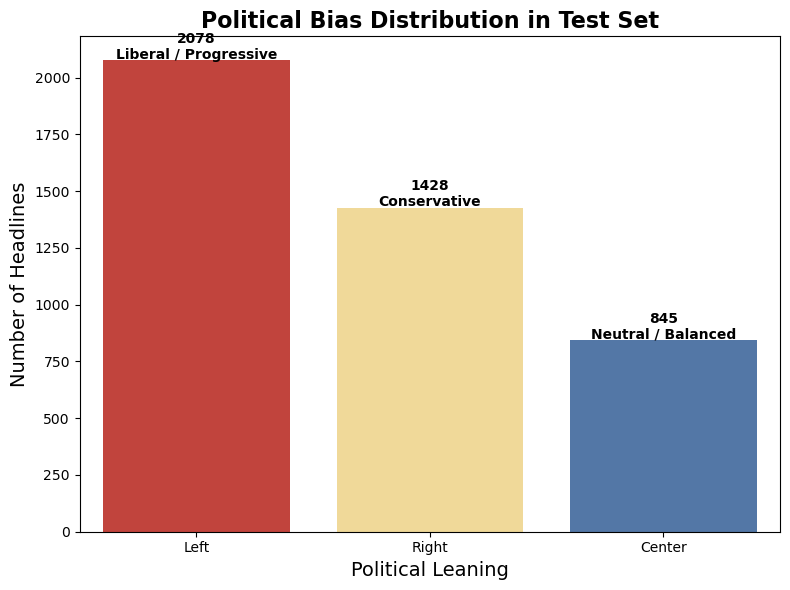

In [18]:
# ===================================================
# ✅ STEP 13 – Visualization
# ===================================================

# Convert tensor labels to integers and map to text
label_names = [reverse_label_map[int(label)] for label in test_dataset["labels"]]
label_counts = pd.Series(label_names).value_counts()

# Create the chart
plt.figure(figsize=(8,6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette=["#d73027", "#fee08b", "#4575b4"])

# Add titles and explanation
plt.title("Political Bias Distribution in Test Set", fontsize=16, fontweight="bold")
plt.xlabel("Political Leaning", fontsize=14)
plt.ylabel("Number of Headlines", fontsize=14)

# Annotate bars with counts & short meaning
meanings = {
    "Left": "Liberal / Progressive",
    "Center": "Neutral / Balanced",
    "Right": "Conservative"
}

for i, (label, count) in enumerate(label_counts.items()):
    plt.text(i, count + 5, f"{count}\n{meanings[label]}", ha='center', fontsize=10, fontweight="bold")

plt.tight_layout()
plt.show()
